**Importing Libraries**

---

In [1]:
# !pip install pyts
# !pip install --upgrade pyts
# !pip install tslearn

In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from pyts.image import GramianAngularField
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
# Downloading Apple stock data from Yahoo Finance
df = yf.download("MSFT", start="2015-07-01", end="2023-05-31")

[*********************100%***********************]  1 of 1 completed


---

In [ ]:
df.shape

(1992, 6)

---

**Step_1**

----

count    1992.000000
mean      155.728765
std        89.961452
min        40.470001
25%        70.267498
50%       132.525002
75%       241.737495
max       343.109985
Name: Close, dtype: float64


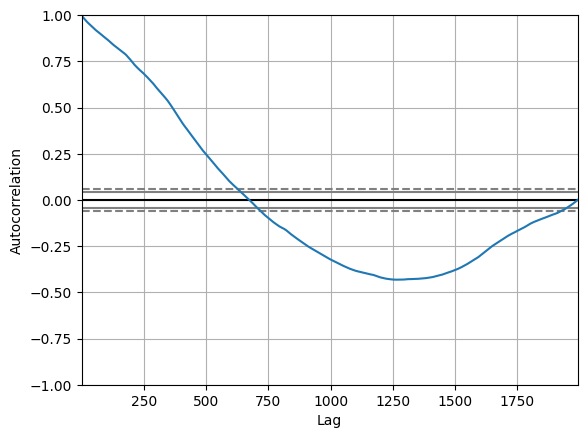

ADF Statistic: 0.08561421816059317
p-value: 0.9650650736640431


In [ ]:
# Step 1a: Gathering and Analyzing Time Series Data

prices = df['Close']

# Calculate summary statistics
summary_stats = prices.describe()
print(summary_stats)

# Calculate autocorrelation and partial autocorrelation
autocorr = pd.plotting.autocorrelation_plot(prices)
plt.show()
# Perform ADF test to assess stationarity
adf_result = adfuller(prices)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

----

count    1991.000000
mean        0.144028
std         3.340747
min       -23.410004
25%        -0.830002
50%         0.089996
75%         1.130001
max        19.949982
Name: Close, dtype: float64


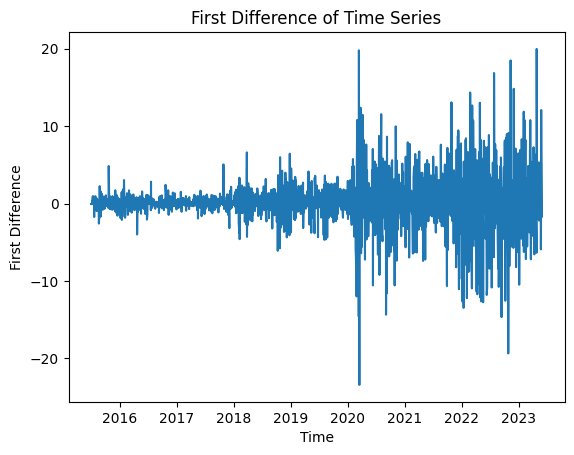

ADF Statistic (Differenced Series): -14.671503268207804
p-value (Differenced Series): 3.2612279131691476e-27


In [ ]:
# Step 1b: Analysis of Transformed Stationary Time Series

# Take the first difference of the prices
prices_diff = prices.diff().dropna()

# Alternative first difference
#prices_diff = np.log(df.Close / df.Close.shift(1)).dropna()

# Calculate summary statistics of the differenced series
summary_stats_diff = prices_diff.describe()
print(summary_stats_diff)

# Plot the differenced series
plt.plot(prices_diff)
plt.xlabel('Time')
plt.ylabel('First Difference')
plt.title('First Difference of Time Series')
plt.show()

# Perform ADF test for the differenced series
adf_result_diff = adfuller(prices_diff)
print('ADF Statistic (Differenced Series):', adf_result_diff[0])
print('p-value (Differenced Series):', adf_result_diff[1])

-----------

count    1991.000000
mean        0.144028
std         3.340747
min       -23.410004
25%        -0.830002
50%         0.089996
75%         1.130001
max        19.949982
Name: Close, dtype: float64


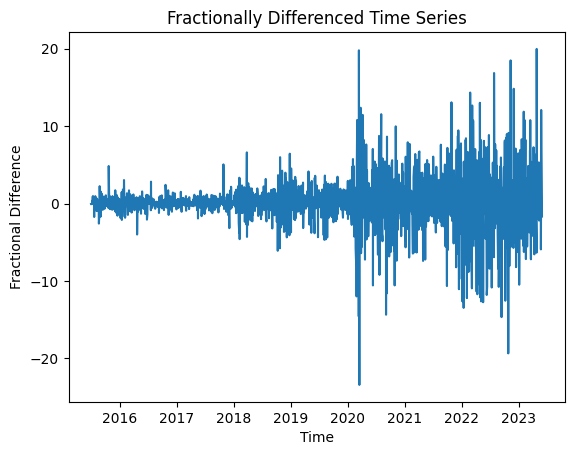

ADF Statistic (Fractionally Differenced Series): -14.671503268207804
p-value (Fractionally Differenced Series): 3.2612279131691476e-27


In [ ]:
# Step 1c: Fractional Differencing for Stationary Time Series

# Perform fractional differencing
frac_diff = prices.diff(1.2).dropna()

# Calculate summary statistics of the fractionally differenced series
summary_stats_frac_diff = frac_diff.describe()
print(summary_stats_frac_diff)

# Plot the fractionally differenced series
plt.plot(frac_diff)
plt.xlabel('Time')
plt.ylabel('Fractional Difference')
plt.title('Fractionally Differenced Time Series')
plt.show()

# Perform ADF test for the fractionally differenced series
adf_result_frac_diff = adfuller(frac_diff)
print('ADF Statistic (Fractionally Differenced Series):', adf_result_frac_diff[0])
print('p-value (Fractionally Differenced Series):', adf_result_frac_diff[1])


---

count    1992.000000
mean     -138.912053
std         0.785224
min      -138.996933
25%      -138.995455
50%      -138.991500
75%      -138.980560
max      -111.278764
Name: Close, dtype: float64


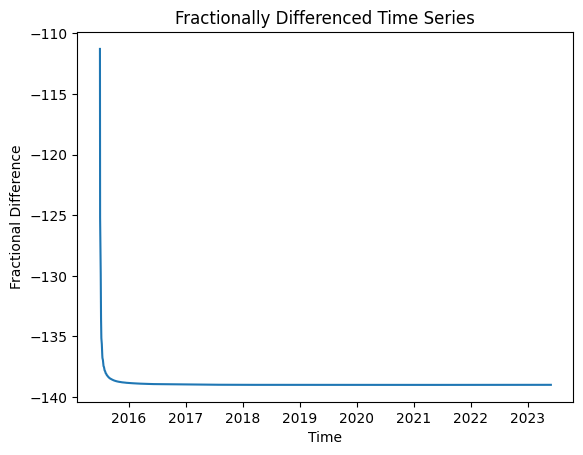

ADF Statistic (Fractionally Differenced Series): -20.732432678046003
p-value (Fractionally Differenced Series): 0.0


In [ ]:
def frac_diff_fn(series, d):
    """Perform fractional differencing with order d on a given series."""
    T = len(series)
    weights = np.array([1] + [-d * (d - 1) / (i * (i - 1)) for i in range(2, T + 1)])
    diff_series = np.cumsum((series - series.mean()) * weights)
    return diff_series

frac_diff_order = 0.5
frac_diff_series = frac_diff_fn(prices, d=frac_diff_order)

# Calculate summary statistics of the fractionally differenced series
summary_stats_frac_diff = pd.Series(frac_diff_series).describe()
print(summary_stats_frac_diff)

# Plot the fractionally differenced series
plt.plot(frac_diff_series)
plt.xlabel('Time')
plt.ylabel('Fractional Difference')
plt.title('Fractionally Differenced Time Series')
plt.show()

# Perform ADF test for the fractionally differenced series
adf_result_frac_diff = adfuller(frac_diff_series)
print('ADF Statistic (Fractionally Differenced Series):', adf_result_frac_diff[0])
print('p-value (Fractionally Differenced Series):', adf_result_frac_diff[1])


---

**Step_2**

---

In [ ]:

# Set the number of lagged time steps to include as inputs
n_lags = 10

# Step 2a: MLP for predicting the level of the time series
# Prepare the data for MLP training and prediction
X_levels = []
y_levels = []

for i in range(n_lags, len(prices)):
    X_levels.append(prices[i - n_lags:i])
    y_levels.append(prices[i])

X_levels = np.array(X_levels)
y_levels = np.array(y_levels)

print('X_levels shape', X_levels.shape)
print('y_levels shape', y_levels.shape)

# Split the data into training and testing sets
X_train_levels, X_test_levels, y_train_levels, y_test_levels = train_test_split(X_levels, y_levels, test_size=0.2, shuffle=False)

# Normalize the data
scaler_levels = MinMaxScaler()
X_train_levels = scaler_levels.fit_transform(X_train_levels)
X_test_levels = scaler_levels.transform(X_test_levels)

# Build the MLP model
model_levels = Sequential()
model_levels.add(Dense(32, input_dim=n_lags, activation='relu'))
model_levels.add(Dense(16, activation='relu'))
model_levels.add(Dense(1))

# Compile the model
model_levels.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
model_levels.fit(X_train_levels, y_train_levels, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred_levels = model_levels.predict(X_test_levels)
mse_levels = mean_squared_error(y_test_levels, y_pred_levels)
print('MSE - Levels Prediction:', mse_levels)



X_levels shape (1982, 10)
y_levels shape (1982,)
13/13 [==============================] - 0s 4ms/step
MSE - Levels Prediction: 106.83220330817257


---

In [ ]:
# Step 2b: MLP for predicting the stationary time series

# Prepare the data for MLP training and prediction
X_stationary = X_levels.copy()
y_stationary = np.diff(prices)
n_samples = min(X_stationary.shape[0], y_stationary.shape[0])
X_stationary = X_stationary[:n_samples]
y_stationary = y_stationary[:n_samples]

# Split the data into training and testing sets
X_train_stationary, X_test_stationary, y_train_stationary, y_test_stationary = train_test_split(X_stationary, y_stationary, test_size=0.2, shuffle=False)

# Normalize the data
scaler_stationary = MinMaxScaler()
X_train_stationary = scaler_stationary.fit_transform(X_train_stationary)
X_test_stationary = scaler_stationary.transform(X_test_stationary)

# Build the MLP model
model_stationary = Sequential()
model_stationary.add(Dense(32, input_dim=n_lags, activation='relu'))
model_stationary.add(Dense(16, activation='relu'))
model_stationary.add(Dense(1))

# Compile the model
model_stationary.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
model_stationary.fit(X_train_stationary, y_train_stationary, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred_stationary = model_stationary.predict(X_test_stationary)
mse_stationary = mean_squared_error(y_test_stationary, y_pred_stationary)
print('MSE - Stationary Prediction:', mse_stationary)

13/13 [==============================] - 0s 2ms/step
MSE - Stationary Prediction: 30.268425850075268


---

In [ ]:
# Step 2c: MLP for predicting the fractionally
# Prepare the data for MLP training and prediction
X_frac_diff = X_levels.copy()
y_frac_diff = prices.diff(1.2)[n_lags:]

print('X_frac_diff shape', X_frac_diff.shape)
print('y_frac_diff shape', y_frac_diff.shape)

# Split the data into training and testing sets
X_train_frac_diff, X_test_frac_diff, y_train_frac_diff, y_test_frac_diff = train_test_split(X_frac_diff, y_frac_diff, test_size=0.2, shuffle=False)

# Normalize the data
scaler_frac_diff = MinMaxScaler()
X_train_frac_diff = scaler_frac_diff.fit_transform(X_train_frac_diff)
X_test_frac_diff = scaler_frac_diff.transform(X_test_frac_diff)

# Build the MLP model
model_frac_diff = Sequential()
model_frac_diff.add(Dense(32, input_dim=n_lags, activation='relu'))
model_frac_diff.add(Dense(16, activation='relu'))
model_frac_diff.add(Dense(1))

# Compile the model
model_frac_diff.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Train the model
model_frac_diff.fit(X_train_frac_diff, y_train_frac_diff, epochs=50, batch_size=32, verbose=0)

# Evaluate the model
y_pred_frac_diff = model_frac_diff.predict(X_test_frac_diff)
mse_frac_diff = mean_squared_error(y_test_frac_diff, y_pred_frac_diff)
print('y_frac_diff mean', y_frac_diff.mean())
print('y_frac_diff std', y_frac_diff.std())
print('y_pred_frac_diff mean', y_pred_frac_diff.mean())
print('y_pred_frac_diff std', y_pred_frac_diff.std())
print('MSE - Fractionally Differenced Prediction:', mse_frac_diff)


X_frac_diff shape (1982, 10)
y_frac_diff shape (1982,)
13/13 [==============================] - 0s 3ms/step
y_frac_diff mean 0.14402118725204083
y_frac_diff std 3.3482672787312557
y_pred_frac_diff mean 0.4512924
y_pred_frac_diff std 0.05434663
MSE - Fractionally Differenced Prediction: 31.248156390896945


---

In [ ]:
# Step 2d: Group Evaluation and Comparison
# Compare the prediction performance of the three models
print('MSE - Levels Prediction:', mse_levels)
print('MSE - Stationary Prediction:', mse_stationary)
print('MSE - Fractionally Differenced Prediction:', mse_frac_diff)

MSE - Levels Prediction: 106.83220330817257
MSE - Stationary Prediction: 30.268425850075268
MSE - Fractionally Differenced Prediction: 31.248156390896945


---

In [ ]:
# Discuss the reasons why some models perform better than others.
# Consider factors such as the nature of the data, the effectiveness of different representations, and the suitability of MLP models for capturing the underlying dynamics of the time series.

---

**Step_3**

---

X_levels (1982, 10)


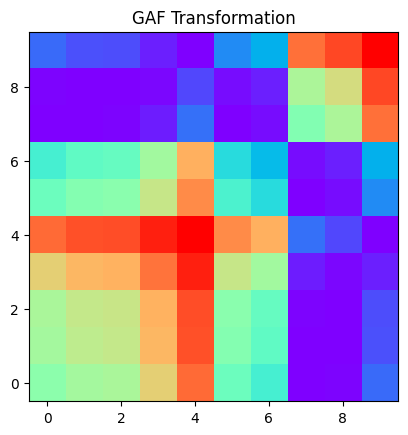

13/13 [==============================] - 0s 2ms/step
Mean Squared Error (Levels Prediction): 23127.907630225563


In [ ]:
# Step 3a: CNN for Levels Prediction using GAF representation
# Assuming X_levels and y_levels are your time series data

# Perform the Gramian Angular Field (GAF) transformation
gaf = GramianAngularField(image_size=10, method='summation')
X_gaf_levels = gaf.fit_transform(X_levels)

print('X_levels', X_levels.shape)

import matplotlib.pyplot as plt
plt.imshow(X_gaf_levels[0], cmap='rainbow', origin='lower')
plt.title('GAF Transformation')
plt.show()

# Split the data into training and testing sets
X_train_gaf_levels, X_test_gaf_levels, y_train_levels, y_test_levels = train_test_split(X_gaf_levels, y_levels, test_size=0.2, shuffle=False)

# Build and train the CNN model
model_levels = Sequential()
model_levels.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(10, 10, 1)))
model_levels.add(Flatten())
model_levels.add(Dense(1))
model_levels.compile(loss='mean_squared_error', optimizer='adam')
model_levels.fit(X_train_gaf_levels[..., np.newaxis], y_train_levels, epochs=100, verbose=0)#, callbacks=[EarlyStopping(patience=10)])

# Evaluate the model
y_pred_levels = model_levels.predict(X_test_gaf_levels[..., np.newaxis])
mse_levels = mean_squared_error(y_test_levels, y_pred_levels)
print("Mean Squared Error (Levels Prediction):", mse_levels)


In [ ]:
# Step 3b: MLP for Stationary Prediction using GAF representation
# Assuming X_stationary and y_stationary are your stationary time series data

# Perform the Gramian Angular Field (GAF) transformation
gaf = GramianAngularField(image_size=10, method='summation')
X_gaf_stationary = gaf.fit_transform(X_stationary)

# Split the data into training and testing sets
X_train_gaf_stationary, X_test_gaf_stationary, y_train_stationary, y_test_stationary = train_test_split(X_gaf_stationary, y_stationary, test_size=0.2, shuffle=False)

n_samples, n_features, n_channels = X_train_gaf_stationary.shape
X_train_gaf_stationary = X_train_gaf_stationary.reshape(n_samples, n_features * n_channels)

# Build and train the MLP model
model_stationary = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)
model_stationary.fit(X_train_gaf_stationary, y_train_stationary)


# Evaluate the model
# Reshape the input data
X_train_gaf_stationary = np.expand_dims(X_train_gaf_stationary, axis=-1)
X_test_gaf_stationary = np.expand_dims(X_test_gaf_stationary, axis=-1)

# Create and train the MLPRegressor model
# model_stationary = MLPRegressor()
# model_stationary.fit(X_train_gaf_stationary, y_train_stationary)

# Make predictions
# Flatten the GAF images
X_test_gaf_stationary_flat = X_test_gaf_stationary.reshape(X_test_gaf_stationary.shape[0], -1)

# Make predictions
y_pred_stationary = model_stationary.predict(X_test_gaf_stationary_flat)

# Calculate Mean Squared Error (MSE)
mse_stationary = mean_squared_error(y_test_stationary, y_pred_stationary)
print("Mean Squared Error (Stationary Prediction):", mse_stationary)


Mean Squared Error (Stationary Prediction): 34.54555303646466


In [ ]:
# Step 3c: CNN for Fractionally-Differenced Prediction using GAF representation
# Assuming X_fractional and y_fractional are your fractionally-differenced time series data

# Perform the Gramian Angular Field (GAF) transformation
X_frac_diff = X_levels.copy()
y_frac_diff = prices.diff(1.2)[n_lags:]

print('X_frac_diff', X_frac_diff.shape)
print('y_frac_diff', y_frac_diff.shape)

gaf = GramianAngularField(image_size=10, method='summation')
X_gaf_fractional = gaf.fit_transform(X_frac_diff)

# Split the data into training and testing sets
X_train_gaf_fractional, X_test_gaf_fractional, y_train_fractional, y_test_fractional = train_test_split(X_gaf_fractional, y_frac_diff, test_size=0.2, shuffle=False)

# Build and train the CNN model
model_fractional = Sequential()
model_fractional.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(10, 10, 1)))
model_fractional.add(Flatten())
model_fractional.add(Dense(1))
model_fractional.compile(loss='mean_squared_error', optimizer='adam')
model_fractional.fit(X_train_gaf_fractional[..., np.newaxis], y_train_fractional, epochs=100, verbose=0)#, callbacks=[EarlyStopping(patience=10)])

# Evaluate the model
y_pred_fractional = model_fractional.predict(X_test_gaf_fractional[..., np.newaxis])
mse_fractional = mean_squared_error(y_test_fractional, y_pred_fractional)
print("Mean Squared Error (Fractionally-Differenced Prediction):", mse_fractional)

X_frac_diff (1982, 10)
y_frac_diff (1982,)
13/13 [==============================] - 0s 2ms/step
Mean Squared Error (Fractionally-Differenced Prediction): 32.80798607421771
